Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151241 entries, 0 to 151240
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   path       151241 non-null  object
 1   symbol_id  151241 non-null  int64 
 2   latex      151241 non-null  object
 3   user_id    151241 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 4.6+ MB
None

Top 10 most common latex symbols:
latex
\int          3162
\sum          3060
\infty        2622
\alpha        2340
\xi           2310
\equiv        2266
\partial      2171
\mathds{R}    2140
\in           2066
\square       1961
Name: count, dtype: int64


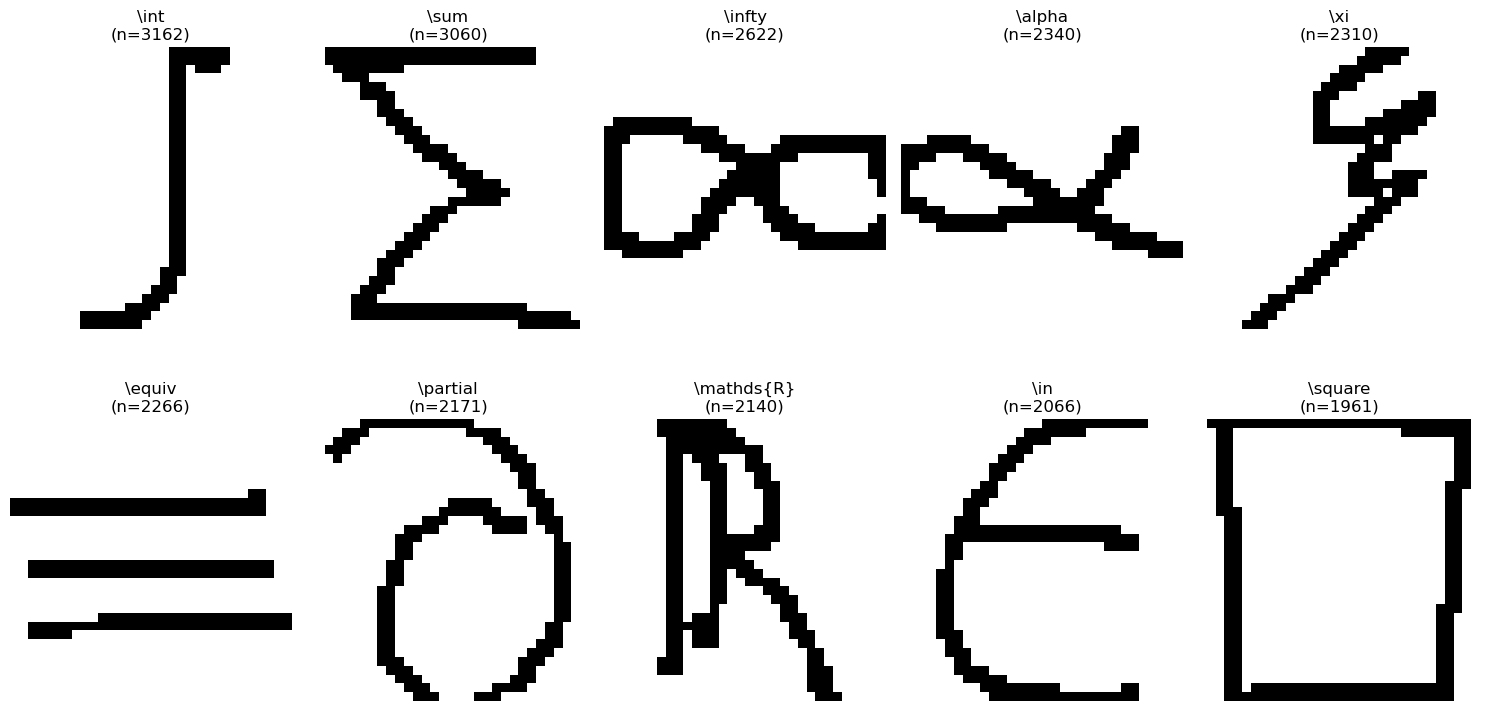


Number of unique users: 463
Average symbols per user: 326.65442764578836

Missing values:
path         0
symbol_id    0
latex        0
user_id      0
dtype: int64
Number of unique latex symbols: 369


Epoch 5 Running accuracy: 0.7618:  11%|█         | 166295/1512410 [1:14:21<10:13:50, 36.55it/s] 

In [ ]:
import cupy as cp
import matplotlib.pyplot as plt
import pandas as pd
import PIL
from tqdm import tqdm 
from sklearn.preprocessing import OneHotEncoder
from PIL import Image


def sigmoid(x):
    return 1 / (1 + cp.exp(-x))

def sigmoid_derivative(x):
    s = sigmoid(x)
    return s * (1 - s)

def tanh(x):
    return (cp.exp(x) - cp.exp(-x)) / (cp.exp(x) + cp.exp(-x))

def tanh_derivative(x):
    t = tanh(x)
    return 1 - t**2

def relu(x):
    return cp.maximum(0, x)

def relu_derivative(x):
    return cp.where(x > 0, 1, 0)

def identity(x):
    return x

def identity_derivative(x):
    return cp.ones_like(x)

def softmax(x):
    # Shift by max for numerical stability
    shifted_x = x - cp.max(x, axis=1, keepdims=True)
    exp_x = cp.exp(shifted_x)
    return exp_x / cp.sum(exp_x, axis=1, keepdims=True)


def cross_entropy(y, logits):
    """Expects y as one-hot labels and logits as raw outputs."""
    y_hat = softmax(logits)
    epsilon = 1e-15
    y_hat = cp.clip(y_hat, epsilon, 1 - epsilon)
    return -cp.sum(y * cp.log(y_hat)) / y.shape[0]

def cross_entropy_derivative(y, logits):
    y_hat = softmax(logits)
    return (y_hat - y) / y.shape[0]

def mse(y, y_hat):
    return cp.mean((y - y_hat) ** 2)

def mse_derivative(y, y_hat):
    return 2 * (y_hat - y)


class function_with_derivative():
    def __init__(self, function_name: str):
        if function_name == 'sigmoid':
            self.f = sigmoid
            self.df = sigmoid_derivative    
        elif function_name == 'tanh':
            self.f = tanh
            self.df = tanh_derivative
        elif function_name == "cross_entropy":
            self.f = cross_entropy
            self.df = cross_entropy_derivative
        elif function_name == "mse":
            self.f = mse
            self.df = mse_derivative
        elif function_name == 'relu':
            self.f = relu
            self.df = relu_derivative
        elif function_name == 'identity':
            self.f = identity
            self.df = identity_derivative
        else:
            raise ValueError(f"Unknown function: {function_name}")
    def __call__(self, x):
        return self.f(x)

# Loss function class (note the swapped argument order)
class loss_fn(function_with_derivative):
    def __call__(self, yhat, y):
        # Here y: true labels, yhat: predictions/logits.
        return self.f(y, yhat)

# Layer class using CuPy
class layer():
    def __init__(self, input_size: int,
                 output_size: int,
                 activation_function=None,
                 bias=False):
        if bias:
            self.w = cp.random.random(size=(input_size + 1, output_size))
        else:
            self.w = cp.random.randn(input_size, output_size) * cp.sqrt(1 / input_size)
        self.grad = cp.zeros_like(self.w)
        # If no activation is provided, use identity.
        if activation_function is not None:
            self.f = function_with_derivative(activation_function)
        else:
            self.f = function_with_derivative('identity')
        self.x = None
        
    def __call__(self, x):
        return self.forward(x)
    
    def forward(self, x):
        self.x = x 
        z = x @ self.w
        a = self.f(z)
        self.activation_grad = self.f.df(z)
        return a
    
    def backward(self, upstream_grad):
        delta = upstream_grad * self.activation_grad
        self.grad = self.x.T @ delta
        return delta @ self.w.T
    
    def update(self, lr):
        self.w -= lr * self.grad
        self.grad = cp.zeros_like(self.w)
        
# MLP class with configurable final activation
class mlp():
    def __init__(self,
                 input_size: int,
                 output_size: int,
                 hidden_layers: list,
                 activation_function='sigmoid',
                 bias=False,
                 final_activation=None):
        self.layers = []
        # First hidden layer
        self.layers.append(layer(input_size, hidden_layers[0], activation_function, bias))
        for i in range(1, len(hidden_layers)):
            self.layers.append(layer(hidden_layers[i - 1], hidden_layers[i], activation_function, bias))
        # Final layer: use provided final_activation, or default to identity
        if final_activation is None:
            final_activation = 'identity'
        self.layers.append(layer(hidden_layers[-1], output_size, final_activation, bias))
        
    def forward(self, z):
        for layer_ in self.layers:
            z = layer_(z)
        return z
    
    def backward(self, loss_grad):
        for layer_ in reversed(self.layers):
            loss_grad = layer_.backward(loss_grad)
            
    def update(self, lr):
        for layer_ in self.layers:
            layer_.update(lr)
            
    def __call__(self, x):
        return self.forward(x)

# -------------------------
# Data loading and preprocessing (using CPU libraries)
data_path = r"C:\Users\saira\OneDrive\Desktop\smai-main\smai-main\a2\q1\classification-task\fold-1\train.csv"
df = pd.read_csv(data_path)
print("Dataset Info:")
print(df.info())

symbol_counts = df['latex'].value_counts()
print("\nTop 10 most common latex symbols:")
print(symbol_counts.head(10))

plt.figure(figsize=(15, 8))
for i, (symbol, count) in enumerate(symbol_counts.head(10).items()):
    img_path = df[df['latex'] == symbol]['path'].iloc[0].lstrip("../../")
    img = Image.open(img_path)
    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.title(f'{symbol}\n(n={count})')
    plt.axis('off')
plt.tight_layout()
plt.show()

user_counts = df['user_id'].value_counts()
print("\nNumber of unique users:", len(user_counts))
print("Average symbols per user:", len(df) / len(user_counts))

print("\nMissing values:")
print(df.isnull().sum())

print(f"Number of unique latex symbols: {len(set(df['latex']))}")

# One-hot encode latex symbols
encoder = OneHotEncoder()
encoder.fit(df[['latex']])

# Custom dataset class
class imgdataset():
    def __init__(self, df: pd.DataFrame):
        self.df = df
    def __getitem__(self, id):
        if isinstance(id, slice):
            rows = self.df.iloc[id]
            filepaths = [path.lstrip("../../") for path in rows["path"]]
            images = [Image.open(filepath) for filepath in filepaths]
            # Convert images to CuPy arrays (float32) and normalize
            images = cp.array([cp.array(image).reshape(-1) for image in images], dtype=cp.float32) / 255.0
            labels = cp.array(encoder.transform(rows[["latex"]]).toarray(), dtype=cp.float32)
            return images, labels
        else:
            row = self.df.iloc[id]
            filepath = row["path"].lstrip("../../")
            image = Image.open(filepath)
            image = cp.array(image).reshape(1, -1) / 255.0
            label = cp.array(encoder.transform([[row["latex"]]]).toarray()[0], dtype=cp.float32)
            return image, label
    def __len__(self):
        return len(self.df)

data = imgdataset(df)

# -------------------------
# Model, Loss, and Training Setup
# For classification with cross-entropy loss, we use cross_entropy as our loss and set the final layer activation to identity.
criterion = loss_fn('mse')
model = mlp(32*32*3, 369, [100, 100, 100], activation_function='sigmoid', final_activation='identity')
lr = 0.0001
batch_size = 5
epochs = 10
training_accs = []

with tqdm(total=epochs * len(data)) as pbar:
    for epoch in range(epochs):
        acc = 0
        for i in range(0, len(data), batch_size):
            images, latex = data[i:i + batch_size]
            try:
                images = images.reshape(batch_size, -1)
            except:
                pass
            # Forward pass
            y_hat = model(images)
            loss = criterion(y_hat, latex)
            # Backward pass (compute gradient w.r.t. predictions)
            loss_grad = criterion.df(latex, y_hat)
            model.backward(loss_grad)
            model.update(lr)
            # Calculate accuracy
            preds = cp.argmax(y_hat, axis=1)
            true_labels = cp.argmax(latex, axis=1)
            acc += int(cp.sum(preds == true_labels))
            pbar.update(1)
            samples_seen = min(i + batch_size, len(data))
            pbar.set_description(f"Epoch {epoch} Running accuracy: {acc / samples_seen:.4f}")
        training_accs.append(acc / len(data))
        # For printing loss, bring it back to CPU if needed.
